In [1]:
import pickle
import numpy as np
import torch
from model import FeedForwardRegressionNet

In [2]:
X_train = pickle.load(open("data/X_train.pkl", "rb"))
X_test = pickle.load(open("data/X_test.pkl", "rb"))
type(X_test)

pandas.core.frame.DataFrame

In [3]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t_state        10000 non-null  object 
 1   t_county       10000 non-null  object 
 2   p_year         10000 non-null  int64  
 3   retrofit       10000 non-null  int64  
 4   retrofit_year  952 non-null    float64
 5   t_hh           10000 non-null  float64
 6   t_rd           10000 non-null  float64
 7   t_rsa          10000 non-null  float64
 8   t_ttlh         10000 non-null  float64
 9   xlong          10000 non-null  float64
 10  ylat           10000 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 859.5+ KB


In [4]:
# Check that columns are in the same order.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 46171 to 56422
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t_state        50000 non-null  object 
 1   t_county       50000 non-null  object 
 2   p_year         50000 non-null  int64  
 3   retrofit       50000 non-null  int64  
 4   retrofit_year  4636 non-null   float64
 5   t_hh           50000 non-null  float64
 6   t_rd           49999 non-null  float64
 7   t_rsa          49999 non-null  float64
 8   t_ttlh         49999 non-null  float64
 9   xlong          50000 non-null  float64
 10  ylat           50000 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 4.6+ MB


In [5]:
X_df = X_test.drop(columns=["retrofit_year"])
X_df["t_state"] = X_df["t_state"].astype('category').cat.codes
X_df["t_county"] = X_df["t_county"].astype('category').cat.codes

In [6]:
print(np.unique(X_df["t_state"]))
print(np.unique(X_df["t_county"]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 21

In [7]:
# Apply standardization.
scaler = pickle.load(open("preprocessed_data/fitted_scaler.pkl", "rb"))

X_num = X_df.drop(columns=["t_state", "t_county"])
print(X_num.shape)
X_num_std = scaler.transform(X_num.to_numpy())

for i, col in enumerate(X_num.columns):
    X_df[col] = X_num_std[:, i]

X_df.info()

(10000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t_state   10000 non-null  int8   
 1   t_county  10000 non-null  int16  
 2   p_year    10000 non-null  float64
 3   retrofit  10000 non-null  float64
 4   t_hh      10000 non-null  float64
 5   t_rd      10000 non-null  float64
 6   t_rsa     10000 non-null  float64
 7   t_ttlh    10000 non-null  float64
 8   xlong     10000 non-null  float64
 9   ylat      10000 non-null  float64
dtypes: float64(8), int16(1), int8(1)
memory usage: 654.4 KB


In [8]:
pickle.dump(torch.tensor(X_df.to_numpy()).float(), open("preprocessed_data/X_test_tensor.pkl", "wb"))

In [9]:
X_tr_tensor = pickle.load(open("preprocessed_data/X_train_tensor.pkl", "rb"))
X_te_tensor = pickle.load(open("preprocessed_data/X_test_tensor.pkl", "rb"))
hyperparameters = pickle.load(open("best_hyperparameters.pkl", "rb"))

HIDDEN_DIMS = hyperparameters["hidden_dims"]
LEARNING_RATE = hyperparameters["learning_rate"]
EMBED_DIM0 = hyperparameters["embed_dim0"]
EMBED_DIM1 = hyperparameters["embed_dim1"]
EPOCHS = hyperparameters["epochs"]

input_dim = X_tr_tensor.shape[1] - 2
vocab_size0 = len(np.unique(X_tr_tensor[:, 0]))
vocab_size1 = len(np.unique(X_tr_tensor[:, 1]))
output_dim = 1

model = FeedForwardRegressionNet(
    input_dim,
    vocab_size0,
    vocab_size1,
    EMBED_DIM0,
    EMBED_DIM1,
    HIDDEN_DIMS,
    output_dim,
)

In [10]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

FeedForwardRegressionNet(
  (embed0): Embedding(42, 16)
  (embed1): Embedding(448, 8)
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

In [12]:
y_tr = model(X_tr_tensor)
y_tr.shape

torch.Size([49999])

In [13]:
y_te = model(X_te_tensor)
y_te.shape

torch.Size([10000])

In [14]:
print(y_tr[0:20])
print(y_te[0:20])

tensor([1552.5631, 1359.0845, 1520.4363, 1487.2595, 1562.6611, 2642.2395,
        1892.9683,  154.3035, 2323.7344,   80.5678, 2292.4368, 3482.4980,
         698.4472, 1698.3464, 1645.1364, 1849.9604, 1539.4504, 1649.7068,
        1341.0472, 2033.6039], grad_fn=<SliceBackward>)
tensor([5195.4097, 2003.1332, 2787.6680, 1490.4749, 1237.4575, 2699.2048,
        2047.2952, 2741.8706, 1260.9941, 1091.7632, 1720.9158, 2125.8259,
        1843.2571, 1679.3566, 2764.8623, 1580.8145, 2252.8062, 1465.7002,
        2034.4580, 1127.5859], grad_fn=<SliceBackward>)


In [15]:
import matplotlib.pyplot as plt

(array([9.33988666e-05, 1.72032435e-04, 5.06654567e-04, 4.49481904e-04,
        2.81913579e-04, 1.37522949e-04, 5.49405040e-05, 1.28766806e-05,
        7.38263023e-06, 6.86756300e-07]),
 array([  61.126694,  643.5749  , 1226.0232  , 1808.4713  , 2390.9197  ,
        2973.3677  , 3555.816   , 4138.264   , 4720.7124  , 5303.1606  ,
        5885.609   ], dtype=float32),
 <BarContainer object of 10 artists>)

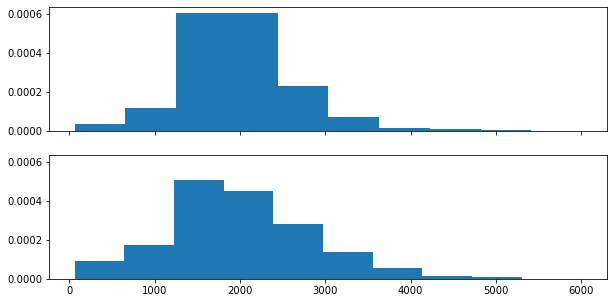

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)

axes[0].hist(y_tr.detach().numpy(), density=True)
axes[1].hist(y_te.detach().numpy(), density=True)

In [24]:
np.savetxt("y.out", y_te.detach().numpy(), delimiter="\n", fmt="%.10f")